# Overlaying slices 3 and 4 of Sph1 to see the paths

In [3]:
# --------- Mounting Drive and Installing Packages ---------

# Are we using Colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If so, connect to Google account and install needed packages
if IN_COLAB:
    # We mount the drive
    from google.colab import drive
    drive.mount('/content/drive')
    ! ls drive/MyDrive/datasets/

    # We install the packages
    ! pip install czifile
    ! python -m pip install "napari[all]"
    ! python -m pip install -U scikit-image
    ! pip install pyclesperanto-prototype
    ! pip install lxml
    ! pip install stardist

# --------- Imports ---------

# General Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch, Circle
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree


# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot


# Filtering Images Imports
import skimage
import skimage.draw
from skimage import morphology
from skimage import img_as_float
from skimage import exposure
from skimage import filters
from skimage.morphology import reconstruction, disk, white_tophat, square, opening
from skimage.restoration import rolling_ball, denoise_bilateral
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, regionprops_table

from scipy.ndimage import gaussian_filter
from pyclesperanto_prototype import imshow


# Image Segmentation Imports
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries

# Teselation Imports
from scipy.spatial import Voronoi, voronoi_plot_2d, distance

# Clustering Imports
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Bounds for coloring the regions
from shapely.geometry import Polygon, box, GeometryCollection, Point, MultiPolygon, LineString
from shapely.validation import explain_validity, make_valid

# Additional Results
import statsmodels.api as sm
import networkx as nx
from scipy.spatial import Delaunay
from scipy import stats


# --------- Napari Configuration ---------

if not IN_COLAB:
  %gui qt


# --------- Opening Images ---------

# Instantiate a Path object
if IN_COLAB:
  czi_file_path = Path(r"drive/MyDrive/datasets/ESTA - Sph1 Z Stack - CTRL SOX2.czi")
else:
  czi_file_path = Path(r"./data/Sph1 Z Stack - CTRL SOX2.czi")

# Read the image and get the CziFile object
with czifile.CziFile(czi_file_path) as czi:
    img = czi.asarray()  # Store image data in 'img' variable
    czi_object = czi  # Store the CziFile object


# --------- Getting rid of the extra dimensions ---------
image_squeezed = np.squeeze(img)


# --------- Separating the channels ---------

# The first channel is the corresponding to stemness
stemness_channel = image_squeezed[0, :, :, :]
# Channel 2 is the optic one
optic_channel = image_squeezed[1, :, :, :]
# Channel 3 contains the nuclei
nuclei_channel = image_squeezed[2, :, :, :]



## Stemness channel processing

In [4]:
# --------- Processing the stemness channel ---------

stemness_array = np.copy(stemness_channel)

# Convert to float
stemness_floats_array = img_as_float(stemness_array)

h = 0.5

seed = stemness_floats_array - h
mask = stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = stemness_floats_array - dilated

# Adaptive Equalization
hdome_adapteq = exposure.equalize_adapthist(hdome, clip_limit=0.03)

## Nuclei channel processing 

In [6]:
# Z slice to analyze

z_slice_3 = 3
z_slice_4 = 4

In [7]:
# 0. Converting the original image to float (originally it's a 'uint16')
image_3d = np.copy(nuclei_channel)
image_2d_z3 = image_3d[z_slice_3]
image_2d_z4 = image_3d[z_slice_4]

image_normalized = image_3d.astype(np.float32) / 65535.0

# 1. Adaptive Histogram Equalization on the 3D image
image_3d_equalized = exposure.equalize_adapthist(image_3d)

# 2. Extract a 2D slice from the equalized 3D image
image_2d_equalized_z3 = image_3d_equalized[z_slice_3]
image_2d_equalized_z4 = image_3d_equalized[z_slice_4]

# 3. Morphological opening to remove small noise
selem = morphology.disk(2)  # using a disk-shaped structuring element of radius 2

image_2d_opened_z3 = morphology.opening(image_2d_equalized_z3, selem)
image_2d_opened_z3 = morphology.area_closing(image_2d_opened_z3, area_threshold=150)

image_2d_opened_z4 = morphology.opening(image_2d_equalized_z4, selem)
image_2d_opened_z4 = morphology.area_closing(image_2d_opened_z4, area_threshold=150)


# 4. Bilateral Filtering (denoising without bluring edges)
image_opened_bilateral_z3 = denoise_bilateral(image_2d_opened_z3, sigma_color=0.05, sigma_spatial=15)
image_opened_bilateral_z4 = denoise_bilateral(image_2d_opened_z4, sigma_color=0.05, sigma_spatial=15)

# 5. Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Perform instance segmentation on the normalized binary image
labels_z3, details_z3 = model.predict_instances(image_opened_bilateral_z3)
labels_z4, details_z4 = model.predict_instances(image_opened_bilateral_z4)

# Extract boundaries from the labels
boundaries_z3 = find_boundaries(labels_z3)
boundaries_z4 = find_boundaries(labels_z4)

# ----------------------------------

# Overlay boundaries on the opened, filtered image
overlay_z3 = np.copy(image_opened_bilateral_z3)
overlay_z3[boundaries_z3] = np.max(image_opened_bilateral_z3)

overlay_z4 = np.copy(image_opened_bilateral_z4)
overlay_z4[boundaries_z4] = np.max(image_opened_bilateral_z4)


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2024-01-10 14:22:01.714895: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2024-01-10 14:22:02.084456: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2024-01-10 14:22:06.069657: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 339738624 exceeds 10% of free system memory.
2024-01-10 14:22:06.928457: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.
2024-01-10 14:22:09.484073: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 679477248 exceeds 10% of free system memory.


## Generating the `DataFrame`

In [8]:
# ======= Generation of the DataFrame with geometrical properties of segmented objects ======

spacing = (1.2364633517553391e-7, 1.2364633517553391e-7)  # in meters for (y, x) dimensions

properties = [
    "label", "area", "centroid", "equivalent_diameter", "bbox_area", "convex_area", "filled_area", "major_axis_length",
    "minor_axis_length", "bbox", "weighted_centroid", "coords",
    "eccentricity", "euler_number", "extent",
    "feret_diameter_max", "max_intensity", "mean_intensity", "min_intensity",
    "orientation", "perimeter", "solidity"
]

# Extract the region properties
regions_z3 = regionprops_table(labels_z3, intensity_image=image_opened_bilateral_z3, properties=properties) # , spacing=spacing
regions_z4 = regionprops_table(labels_z4, intensity_image=image_opened_bilateral_z4, properties=properties) # , spacing=spacing

# Convert the result to a DataFrame
df_z3 = pd.DataFrame(regions_z3)
df_z4 = pd.DataFrame(regions_z4)


# ========== Defining in_spheroid cells ============
# We consider cells to be in the spheroid if they are within a certain radius from the center.

# ------------------------- z = 3 -----------------------
# 1. Calculate center_of_spheroid FOR IN_SPHEROID (DIFFERENT FROM THE ONE FOR THE ARTIFICIAL POINTS)
center_of_spheroid_aux_z3 = df_z3[['centroid-0', 'centroid-1']].mean().values
# we move the center a bit to the bottom left
center_of_spheroid_aux_z3[0] += 0
center_of_spheroid_aux_z3[1] -= 0

# 2. Calculate total_spheroid_radius
df_z3['distance_to_center'] = np.sqrt((df_z3['centroid-0'] - center_of_spheroid_aux_z3[0])**2 + 
                                   (df_z3['centroid-1'] - center_of_spheroid_aux_z3[1])**2)
total_spheroid_radius_z3 = df_z3['distance_to_center'].max()

# 3. Define alpha and add the 'in_spheroid' column
alpha_z3 = 0.95

df_z3['in_spheroid'] = df_z3['distance_to_center'] <= alpha_z3 * total_spheroid_radius_z3

# ------------------------- z = 4 -----------------------
# 1. Calculate center_of_spheroid FOR IN_SPHEROID (DIFFERENT FROM THE ONE FOR THE ARTIFICIAL POINTS)
center_of_spheroid_aux_z4 = df_z4[['centroid-0', 'centroid-1']].mean().values
# we move the center a bit to the bottom left
center_of_spheroid_aux_z4[0] += 100
center_of_spheroid_aux_z4[1] -= 100

# 2. Calculate total_spheroid_radius
df_z4['distance_to_center'] = np.sqrt((df_z4['centroid-0'] - center_of_spheroid_aux_z4[0])**2 + 
                                   (df_z4['centroid-1'] - center_of_spheroid_aux_z4[1])**2)
total_spheroid_radius_z4 = df_z4['distance_to_center'].max()

# 3. Define alpha and add the 'in_spheroid' column
alpha_z4 = 0.55

df_z4['in_spheroid'] = df_z4['distance_to_center'] <= alpha_z4 * total_spheroid_radius_z4


## Generating Voronoi objects

In [9]:
# --------- Voronoi Tessellation z = 3 ---------
# (including artificial points to limit cell regions)

# Centers of segmented nuclei
centroids_z3 = df_z3[['centroid-1', 'centroid-0']].values

# (IN_SPH) Filter centroids for cells within the spheroid
centroids_in_sph_z3 = df_z3[df_z3['in_spheroid'] == True][['centroid-1', 'centroid-0']].values

# Calculate the center and the radius for the large circle
center_of_spheroid_z3 = np.mean(centroids_z3, axis=0)
total_spheroid_radius_z3 = np.max(np.sqrt(np.sum((centroids_z3 - center_of_spheroid_z3)**2, axis=1)))

# (IN_SPH) Recalculate the center and the radius for the large circle using only the centroids within the spheroid
center_of_spheroid_in_sph_z3 = center_of_spheroid_aux_z3[::-1]  # this had the 0 component first, but we want the 1 component first
total_spheroid_radius_in_sph_z3 = alpha_z3 * total_spheroid_radius_z3

# Define the radius of the large bounding circle
gamma_z3 = 1.2
large_circle_radius_z3 = gamma_z3 * total_spheroid_radius_z3
large_circle_radius_in_sph_z3 = gamma_z3 * total_spheroid_radius_in_sph_z3

# Generate points on the large circle to bound the Voronoi cells
num_artificial_points_z3 = 100
angles_z3 = np.linspace(0, 2 * np.pi, num_artificial_points_z3, endpoint=False)
artificial_points_x_z3 = center_of_spheroid_z3[0] + large_circle_radius_z3 * np.cos(angles_z3)
artificial_points_y_z3 = center_of_spheroid_z3[1] + large_circle_radius_z3 * np.sin(angles_z3)
artificial_points_z3 = np.stack((artificial_points_x_z3, artificial_points_y_z3), axis=1)

# (IN_SPH) Generate points on the large circle to bound the Voronoi cells
artificial_points_x_in_sph_z3 = center_of_spheroid_in_sph_z3[0] + large_circle_radius_in_sph_z3 * np.cos(angles_z3)
artificial_points_y_in_sph_z3 = center_of_spheroid_in_sph_z3[1] + large_circle_radius_in_sph_z3 * np.sin(angles_z3)
artificial_points_in_sph_z3 = np.stack((artificial_points_x_in_sph_z3, artificial_points_y_in_sph_z3), axis=1)

# Combine the original centroids with the artificial points
all_points_z3 = np.vstack((centroids_z3, artificial_points_z3))
all_points_in_sph_z3 = np.vstack((centroids_in_sph_z3, artificial_points_in_sph_z3))  # Only centroids within the spheroid

# Calculate the Voronoi diagram for all combined points
vor_z3 = Voronoi(all_points_z3)

# (IN_SPH) Calculate the Voronoi diagram for points within the spheroid (ONLY FOR PLOTTING PURPOSES)
vor_in_sph_z3 = Voronoi(all_points_in_sph_z3)

In [10]:
# --------- Voronoi Tessellation z = 4 ---------
# (including artificial points to limit cell regions)

# Centers of segmented nuclei
centroids_z4 = df_z4[['centroid-1', 'centroid-0']].values

# (IN_SPH) Filter centroids for cells within the spheroid
centroids_in_sph_z4 = df_z4[df_z4['in_spheroid'] == True][['centroid-1', 'centroid-0']].values

# Calculate the center and the radius for the large circle
center_of_spheroid_z4 = np.mean(centroids_z4, axis=0)
total_spheroid_radius_z4 = np.max(np.sqrt(np.sum((centroids_z4 - center_of_spheroid_z4)**2, axis=1)))

# (IN_SPH) Recalculate the center and the radius for the large circle using only the centroids within the spheroid
center_of_spheroid_in_sph_z4 = center_of_spheroid_aux_z4[::-1]  # this had the 0 component first, but we want the 1 component first
total_spheroid_radius_in_sph_z4 = alpha_z4 * total_spheroid_radius_z4

# Define the radius of the large bounding circle
gamma_z4 = 1.2
large_circle_radius_z4 = gamma_z4 * total_spheroid_radius_z4
large_circle_radius_in_sph_z4 = gamma_z4 * total_spheroid_radius_in_sph_z4

# Generate points on the large circle to bound the Voronoi cells
num_artificial_points_z4 = 100
angles_z4 = np.linspace(0, 2 * np.pi, num_artificial_points_z4, endpoint=False)
artificial_points_x_z4 = center_of_spheroid_z4[0] + large_circle_radius_z4 * np.cos(angles_z4)
artificial_points_y_z4 = center_of_spheroid_z4[1] + large_circle_radius_z4 * np.sin(angles_z4)
artificial_points_z4 = np.stack((artificial_points_x_z4, artificial_points_y_z4), axis=1)

# (IN_SPH) Generate points on the large circle to bound the Voronoi cells
artificial_points_x_in_sph_z4 = center_of_spheroid_in_sph_z4[0] + large_circle_radius_in_sph_z4 * np.cos(angles_z4)
artificial_points_y_in_sph_z4 = center_of_spheroid_in_sph_z4[1] + large_circle_radius_in_sph_z4 * np.sin(angles_z4)
artificial_points_in_sph_z4 = np.stack((artificial_points_x_in_sph_z4, artificial_points_y_in_sph_z4), axis=1)

# Combine the original centroids with the artificial points
all_points_z4 = np.vstack((centroids_z4, artificial_points_z4))
all_points_in_sph_z4 = np.vstack((centroids_in_sph_z4, artificial_points_in_sph_z4))  # Only centroids within the spheroid

# Calculate the Voronoi diagram for all combined points
vor_z4 = Voronoi(all_points_z4)

# (IN_SPH) Calculate the Voronoi diagram for points within the spheroid (ONLY FOR PLOTTING PURPOSES)
vor_in_sph_z4 = Voronoi(all_points_in_sph_z4)

## Counting Fluorescence Intensity

In [11]:
# --------- Counting Fluorescence Intensity in each region of z = 3 ---------
# (excluding artificial points)

sox2_img_z3 = hdome[z_slice_3]
# sox2_img = average_hdome_adapteq

# Create a blank image for Voronoi segmentation
voronoi_regions_z3 = np.zeros_like(sox2_img_z3, dtype=int)

intensity_sums_z3 = [0] * len(centroids_z3)  # Initialize intensity sums with zeros

# Iterate through each original point's region
for point_idx, region_idx in enumerate(vor_z3.point_region[:len(centroids_z3)]):  # Only original points
    region = vor_z3.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon_points = [vor_z3.vertices[i] for i in region]
        polygon = Polygon(polygon_points)

        # Fix any invalid polygons
        if not polygon.is_valid:
            polygon = polygon.buffer(0)

        # Draw the polygon to get the region
        rr, cc = skimage.draw.polygon(polygon.exterior.xy[1], polygon.exterior.xy[0], voronoi_regions_z3.shape)
        voronoi_regions_z3[rr, cc] = point_idx + 1  # Add 1 to avoid using zero as a label
        intensity_sums_z3[point_idx] += np.sum(sox2_img_z3[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df_z3['Fluorescence_Intensity'] = intensity_sums_z3

In [12]:
# --------- Counting Fluorescence Intensity in each region of z = 4 ---------
# (excluding artificial points)

sox2_img_z4 = hdome[z_slice_4]
# sox2_img = average_hdome_adapteq

# Create a blank image for Voronoi segmentation
voronoi_regions_z4 = np.zeros_like(sox2_img_z4, dtype=int)

intensity_sums_z4 = [0] * len(centroids_z4)  # Initialize intensity sums with zeros

# Iterate through each original point's region
for point_idx, region_idx in enumerate(vor_z4.point_region[:len(centroids_z4)]):  # Only original points
    region = vor_z4.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon_points = [vor_z4.vertices[i] for i in region]
        polygon = Polygon(polygon_points)

        # Fix any invalid polygons
        if not polygon.is_valid:
            polygon = polygon.buffer(0)

        # Draw the polygon to get the region
        rr, cc = skimage.draw.polygon(polygon.exterior.xy[1], polygon.exterior.xy[0], voronoi_regions_z4.shape)
        voronoi_regions_z4[rr, cc] = point_idx + 1  # Add 1 to avoid using zero as a label
        intensity_sums_z4[point_idx] += np.sum(sox2_img_z4[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df_z4['Fluorescence_Intensity'] = intensity_sums_z4

## Clustering: `tails_cut_in_spheroid_GMM_stemness`

In [13]:
# ========== EXCLUDING CELLS OUTSIDE THE SPHEROID AND CUTTING DISTRIBUTION TAILS: Z = 3 ==========


# Calculate the 5th and 95th percentile values of Fluorescence_Intensity within the spheroid
lower_threshold_z3 = df_z3[df_z3['in_spheroid']]['Fluorescence_Intensity'].quantile(0.05)
upper_threshold_z3 = df_z3[df_z3['in_spheroid']]['Fluorescence_Intensity'].quantile(0.95)

# Initialize the 'tails_cut_in_spheroid_GMM_stemness' column with NaN (into which we'll map the GMM labels)
df_z3['tails_cut_in_spheroid_GMM_stemness'] = np.nan

# Assign 0 to the 5% lowest intensity regions within the spheroid (non-stem)
df_z3.loc[(df_z3['Fluorescence_Intensity'] <= lower_threshold_z3) & (df_z3['in_spheroid']), 'tails_cut_in_spheroid_GMM_stemness'] = 0

# Assign 1 to the 95% highest intensity regions within the spheroid (stem)
df_z3.loc[(df_z3['Fluorescence_Intensity'] >= upper_threshold_z3) & (df_z3['in_spheroid']), 'tails_cut_in_spheroid_GMM_stemness'] = 1

# Filter the dataframe for the regions to be included in GMM clustering (inside the spheroid and not in the tails)
filtered_df_z3 = df_z3[(df_z3['Fluorescence_Intensity'] > lower_threshold_z3) & 
                 (df_z3['Fluorescence_Intensity'] < upper_threshold_z3) & 
                 (df_z3['in_spheroid'])].copy()

# Reshape the Fluorescence_Intensity data for clustering
X_z3 = filtered_df_z3['Fluorescence_Intensity'].values.reshape(-1, 1)

# Set a seed for reproducibility
random_state_z3 = 42

# Perform GMM clustering with k=2, using the random_state for reproducibility
gmm_z3 = GaussianMixture(n_components=2, random_state=random_state_z3)
gmm_z3.fit(X_z3)


# Get the clustering labels
labels_z3 = gmm_z3.predict(X_z3)

# Compute the mean fluorescence intensity for each cluster
cluster_means_z3 = np.array([filtered_df_z3['Fluorescence_Intensity'][labels_z3 == i].mean() for i in np.unique(labels_z3)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity_z3 = cluster_means_z3.argmax()
label_lower_intensity_z3 = cluster_means_z3.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels_z3[labels_z3 == label_higher_intensity_z3] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels_z3[labels_z3 == label_lower_intensity_z3] = 0
labels_z3[labels_z3 == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df_z3.loc[:, 'tails_cut_in_spheroid_GMM_stemness'] = labels_z3


# Map the GMM_stemness labels back to the original df
df_z3.update(filtered_df_z3[['tails_cut_in_spheroid_GMM_stemness']])

# Note: Regions outside the spheroid or in the tails are already handled with NaN or the set values (0 and 1)

In [14]:
# ========== EXCLUDING CELLS OUTSIDE THE SPHEROID AND CUTTING DISTRIBUTION TAILS: Z = 3 ==========


# Calculate the 5th and 95th percentile values of Fluorescence_Intensity within the spheroid
lower_threshold_z4 = df_z4[df_z4['in_spheroid']]['Fluorescence_Intensity'].quantile(0.05)
upper_threshold_z4 = df_z4[df_z4['in_spheroid']]['Fluorescence_Intensity'].quantile(0.95)

# Initialize the 'tails_cut_in_spheroid_GMM_stemness' column with NaN (into which we'll map the GMM labels)
df_z4['tails_cut_in_spheroid_GMM_stemness'] = np.nan

# Assign 0 to the 5% lowest intensity regions within the spheroid (non-stem)
df_z4.loc[(df_z4['Fluorescence_Intensity'] <= lower_threshold_z4) & (df_z4['in_spheroid']), 'tails_cut_in_spheroid_GMM_stemness'] = 0

# Assign 1 to the 95% highest intensity regions within the spheroid (stem)
df_z4.loc[(df_z4['Fluorescence_Intensity'] >= upper_threshold_z4) & (df_z4['in_spheroid']), 'tails_cut_in_spheroid_GMM_stemness'] = 1

# Filter the dataframe for the regions to be included in GMM clustering (inside the spheroid and not in the tails)
filtered_df_z4 = df_z4[(df_z4['Fluorescence_Intensity'] > lower_threshold_z4) & 
                 (df_z4['Fluorescence_Intensity'] < upper_threshold_z4) & 
                 (df_z4['in_spheroid'])].copy()

# Reshape the Fluorescence_Intensity data for clustering
X_z4 = filtered_df_z4['Fluorescence_Intensity'].values.reshape(-1, 1)

# Set a seed for reproducibility
random_state_z4 = 42

# Perform GMM clustering with k=2, using the random_state for reproducibility
gmm_z4 = GaussianMixture(n_components=2, random_state=random_state_z4)
gmm_z4.fit(X_z4)


# Get the clustering labels
labels_z4 = gmm_z4.predict(X_z4)

# Compute the mean fluorescence intensity for each cluster
cluster_means_z4 = np.array([filtered_df_z4['Fluorescence_Intensity'][labels_z4 == i].mean() for i in np.unique(labels_z4)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity_z4 = cluster_means_z4.argmax()
label_lower_intensity_z4 = cluster_means_z4.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels_z4[labels_z4 == label_higher_intensity_z4] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels_z4[labels_z4 == label_lower_intensity_z4] = 0
labels_z4[labels_z4 == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df_z4.loc[:, 'tails_cut_in_spheroid_GMM_stemness'] = labels_z4


# Map the GMM_stemness labels back to the original df
df_z4.update(filtered_df_z4[['tails_cut_in_spheroid_GMM_stemness']])

# Note: Regions outside the spheroid or in the tails are already handled with NaN or the set values (0 and 1)

## Individual Final Voronoi Plots

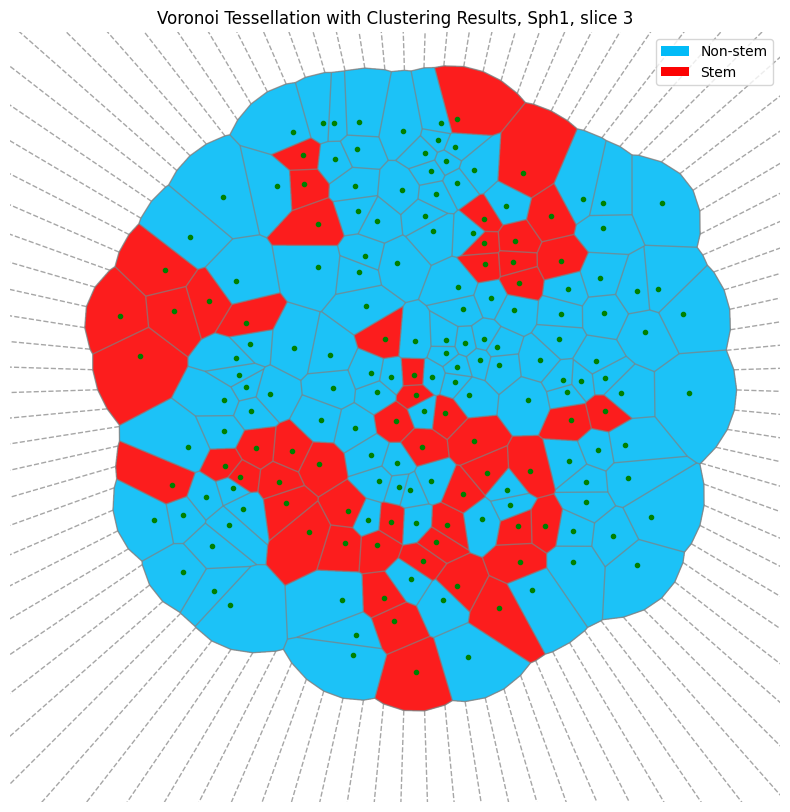

In [21]:
# ========== CRITERION: tails_cut_in_spheroid_GMM_stemness; Z = 3 ==========


# Define a soft, pastel colormap
pastel_cmap_z3 = ListedColormap(['#02bbf7', '#fc0303'])  # light blue and light red

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(image_opened_bilateral, cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay_z3 = np.zeros(image_opened_bilateral_z3.shape + (4,), dtype=np.uint8)  # 4 for RGBA

# ---

# # Center of spheroid
# ax.plot(*center_of_spheroid[::1], color='orange', marker='x')

# # Coloring Circle
# circle = Circle(center_of_spheroid[::1], large_circle_radius, fill=False, color='green', linestyle='--', label='Artificial Boundary')
# ax.add_patch(circle)

# # Max distance circle
# circle = Circle(center_of_spheroid[::1], total_spheroid_radius, fill=False, color='orange', linestyle='--', label='Max Distance Circle')
# ax.add_patch(circle)

# # in_spheroid Circle
# circle = Circle(center_of_spheroid[::1], alpha * total_spheroid_radius, fill=False, color='pink', linestyle='--', label='in_spheroid Circle')
# ax.add_patch(circle)

# ---

# Create a mapping from the 'in_spheroid' centroids to their original DataFrame index
in_spheroid_indices_z3 = df_z3[df_z3['in_spheroid'] == True].index

# Fill the Voronoi regions with color based on 'tails_cut_in_spheroid_GMM_stemness'
for point_idx, region_idx in enumerate(vor_in_sph_z3.point_region):
    region = vor_in_sph_z3.regions[region_idx]
    if not -1 in region and len(region) > 0 and point_idx < len(centroids_in_sph_z3):  # Ensure we only color the original points
        polygon = [vor_in_sph_z3.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], image_opened_bilateral_z3.shape)
        
        # Get the corresponding index in the original DataFrame using the mapping
        original_idx = in_spheroid_indices_z3[point_idx]
        
        # Get the color based on 'tails_cut_in_spheroid_GMM_stemness'
        stemness_value = df_z3.at[original_idx, 'tails_cut_in_spheroid_GMM_stemness']
        
        # Check if stemness_value is not NaN before setting the color
        if not np.isnan(stemness_value):
            color = pastel_cmap_z3(stemness_value)
            voronoi_overlay_z3[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay_z3, alpha=0.9)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor_in_sph_z3, ax=ax, show_points=False, show_vertices=False, line_colors='gray', line_width=1, line_alpha=0.7)

# # Overlay the fluorescence channel using a colormap.
# ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids
for (r, c) in centroids_in_sph_z3:
    ax.plot(r, c, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap_z3(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap_z3(1), label='Stem')]

# # Let's include the legend for the circles
# legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
#                  Patch(facecolor=pastel_cmap(1), label='Stem'),
#                  Line2D([0], [0], color='green', linestyle='--', label='Artificial Boundary'),
#                  Line2D([0], [0], color='orange', linestyle='--', label='Max Distance Circle'),
#                  Line2D([0], [0], color='pink', linestyle='--', label='in_spheroid Circle')]

ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral_z3.shape[1]])
ax.set_ylim([image_opened_bilateral_z3.shape[0], 0])
ax.set_title('Voronoi Tessellation with Clustering Results, Sph1, slice 3')
plt.axis('off')

plt.show()

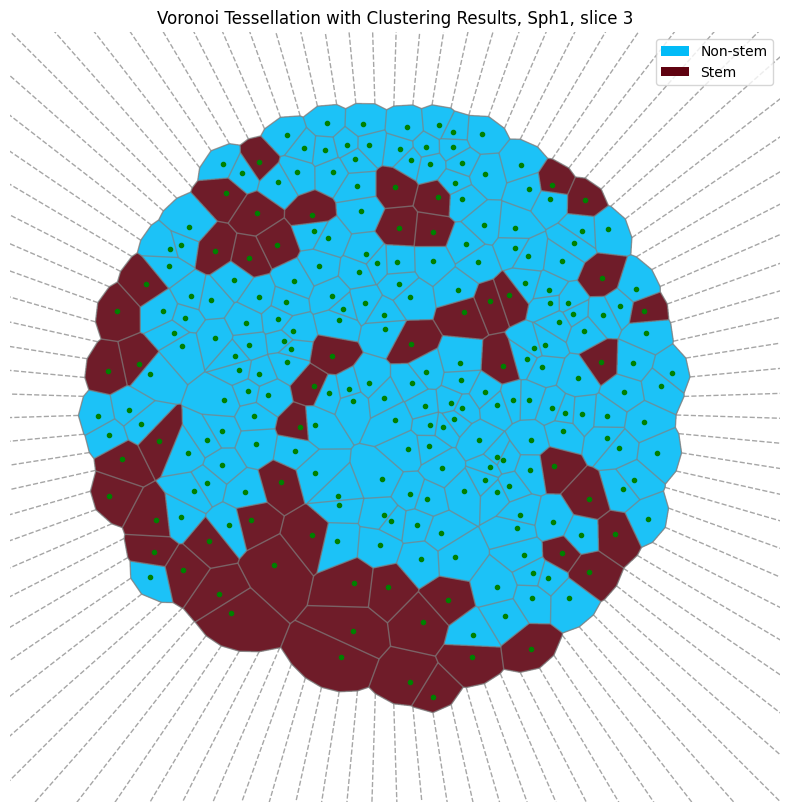

In [28]:
# ========== CRITERION: tails_cut_in_spheroid_GMM_stemness; Z = 4 ==========


# Define a soft, pastel colormap
pastel_cmap_z4 = ListedColormap(['#02bbf7', '#5f0210'])  # light blue and darker red (light red #fc0303)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(image_opened_bilateral, cmap='gray')

# Create an empty image to overlay the Voronoi regions
voronoi_overlay_z4 = np.zeros(image_opened_bilateral_z4.shape + (4,), dtype=np.uint8)  # 4 for RGBA

# ---

# # Center of spheroid
# ax.plot(*center_of_spheroid[::1], color='orange', marker='x')

# # Coloring Circle
# circle = Circle(center_of_spheroid[::1], large_circle_radius, fill=False, color='green', linestyle='--', label='Artificial Boundary')
# ax.add_patch(circle)

# # Max distance circle
# circle = Circle(center_of_spheroid[::1], total_spheroid_radius, fill=False, color='orange', linestyle='--', label='Max Distance Circle')
# ax.add_patch(circle)

# # in_spheroid Circle
# circle = Circle(center_of_spheroid[::1], alpha * total_spheroid_radius, fill=False, color='pink', linestyle='--', label='in_spheroid Circle')
# ax.add_patch(circle)

# ---

# Create a mapping from the 'in_spheroid' centroids to their original DataFrame index
in_spheroid_indices_z4 = df_z4[df_z4['in_spheroid'] == True].index

# Fill the Voronoi regions with color based on 'tails_cut_in_spheroid_GMM_stemness'
for point_idx, region_idx in enumerate(vor_in_sph_z4.point_region):
    region = vor_in_sph_z4.regions[region_idx]
    if not -1 in region and len(region) > 0 and point_idx < len(centroids_in_sph_z4):  # Ensure we only color the original points
        polygon = [vor_in_sph_z4.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], image_opened_bilateral_z4.shape)
        
        # Get the corresponding index in the original DataFrame using the mapping
        original_idx = in_spheroid_indices_z4[point_idx]
        
        # Get the color based on 'tails_cut_in_spheroid_GMM_stemness'
        stemness_value = df_z4.at[original_idx, 'tails_cut_in_spheroid_GMM_stemness']
        
        # Check if stemness_value is not NaN before setting the color
        if not np.isnan(stemness_value):
            color = pastel_cmap_z4(stemness_value)
            voronoi_overlay_z4[rr, cc] = np.array(color)*255  # Assuming 'color' is an RGBA tuple

# Display the colored Voronoi overlay
ax.imshow(voronoi_overlay_z4, alpha=0.9)  # Adjust alpha for desired transparency

# Overlay the Voronoi diagram without the points, with yellow lines for boundaries
voronoi_plot_2d(vor_in_sph_z4, ax=ax, show_points=False, show_vertices=False, line_colors='gray', line_width=1, line_alpha=0.7)

# # Overlay the fluorescence channel using a colormap.
# ax.imshow(hdome[z_slice], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids
for (r, c) in centroids_in_sph_z4:
    ax.plot(r, c, 'g.')  # green dot for each centroid

# Legend for the Voronoi region colors
legend_labels = [Patch(facecolor=pastel_cmap_z4(0), label='Non-stem'), 
                 Patch(facecolor=pastel_cmap_z4(1), label='Stem')]

# # Let's include the legend for the circles
# legend_labels = [Patch(facecolor=pastel_cmap(0), label='Non-stem'), 
#                  Patch(facecolor=pastel_cmap(1), label='Stem'),
#                  Line2D([0], [0], color='green', linestyle='--', label='Artificial Boundary'),
#                  Line2D([0], [0], color='orange', linestyle='--', label='Max Distance Circle'),
#                  Line2D([0], [0], color='pink', linestyle='--', label='in_spheroid Circle')]

ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral_z4.shape[1]])
ax.set_ylim([image_opened_bilateral_z4.shape[0], 0])
ax.set_title('Voronoi Tessellation with Clustering Results, Sph1, slice 3')
plt.axis('off')

plt.show()

## Overlaying Plots

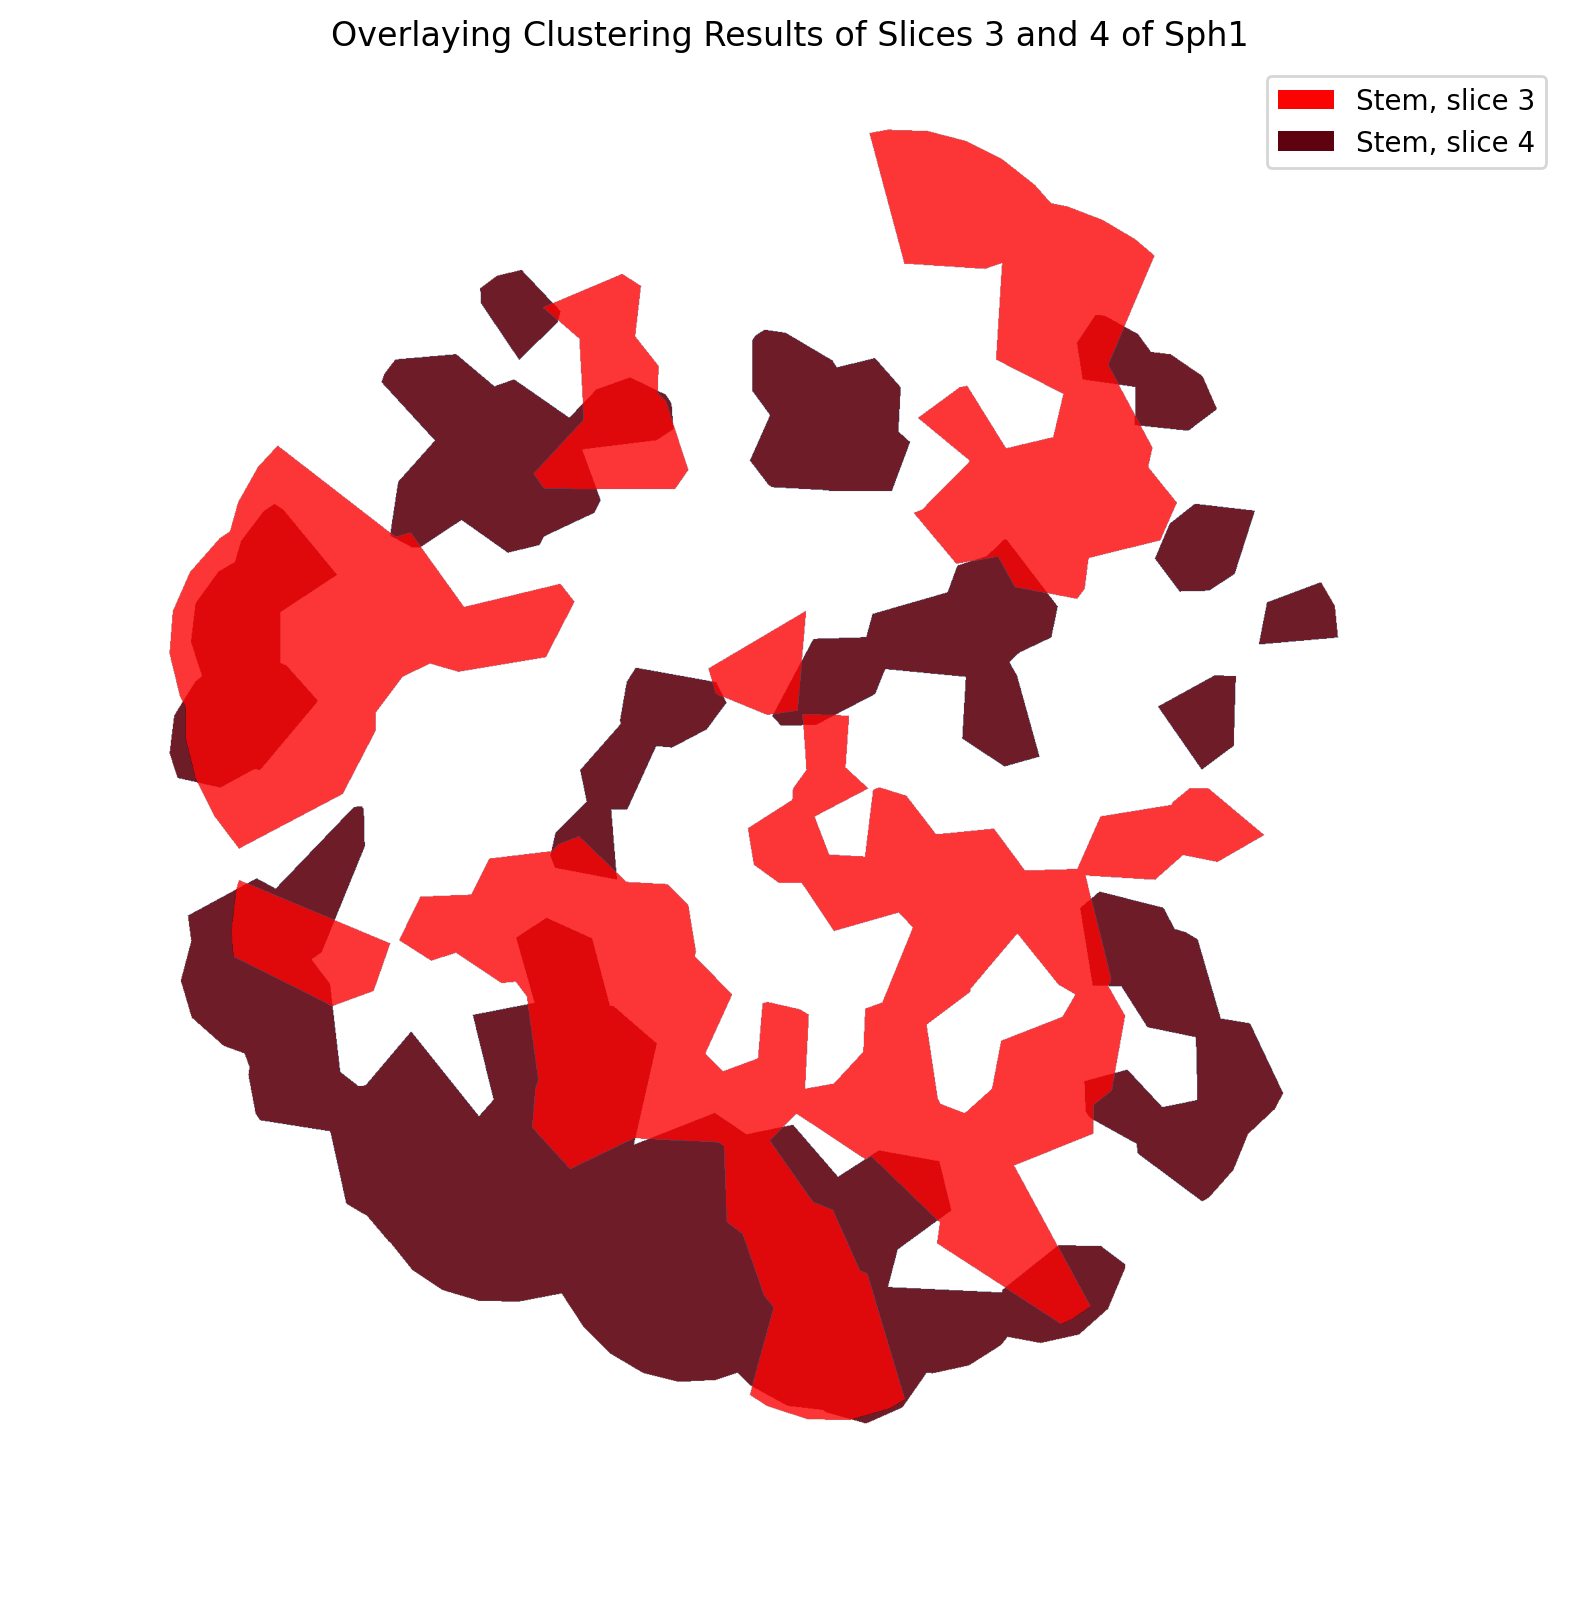

In [61]:
# def make_non_stem_transparent(overlay, non_stem_color):
#     # Convert the hex color to RGB
#     non_stem_color_rgb = np.array([int(non_stem_color[i:i+2], 16) for i in (1, 3, 5)])

#     # Iterate through each pixel
#     for i in range(overlay.shape[0]):
#         for j in range(overlay.shape[1]):
#             # If the pixel matches the non-stem color, make it transparent
#             if np.array_equal(overlay[i, j, :3], non_stem_color_rgb):
#                 overlay[i, j, 3] = 0

def make_non_stem_transparent(overlay, non_stem_color):
    # Convert the hex color to RGB
    non_stem_color_rgb = np.array([int(non_stem_color[i:i+2], 16) for i in (1, 3, 5)])

    # Create a boolean mask where the pixel matches the non-stem color
    mask = np.all(overlay[:, :, :3] == non_stem_color_rgb, axis=-1)

    # Set the alpha channel to 0 where the mask is True
    overlay[mask, 3] = 0


# Copying for avoiding changing the originals
voronoi_overlay_z3_copy = np.copy(voronoi_overlay_z3)
voronoi_overlay_z4_copy = np.copy(voronoi_overlay_z4)

# Apply the function to both overlays
make_non_stem_transparent(voronoi_overlay_z3_copy, '#02bbf7')
make_non_stem_transparent(voronoi_overlay_z4_copy, '#02bbf7')

# Now, proceed with the plotting
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.imshow(voronoi_overlay_z4_copy, alpha=0.9)
ax.imshow(voronoi_overlay_z3_copy, alpha=0.8)

# Legend for the Voronoi region colors
legend_labels = [
    Patch(facecolor=pastel_cmap_z3(1), label='Stem, slice 3'),
    Patch(facecolor=pastel_cmap_z4(1), label='Stem, slice 4')
]

ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral_z4.shape[1]])
ax.set_ylim([image_opened_bilateral_z4.shape[0], 0])
ax.set_title('Overlaying Clustering Results of Slices 3 and 4 of Sph1')
plt.axis('off')

plt.show()


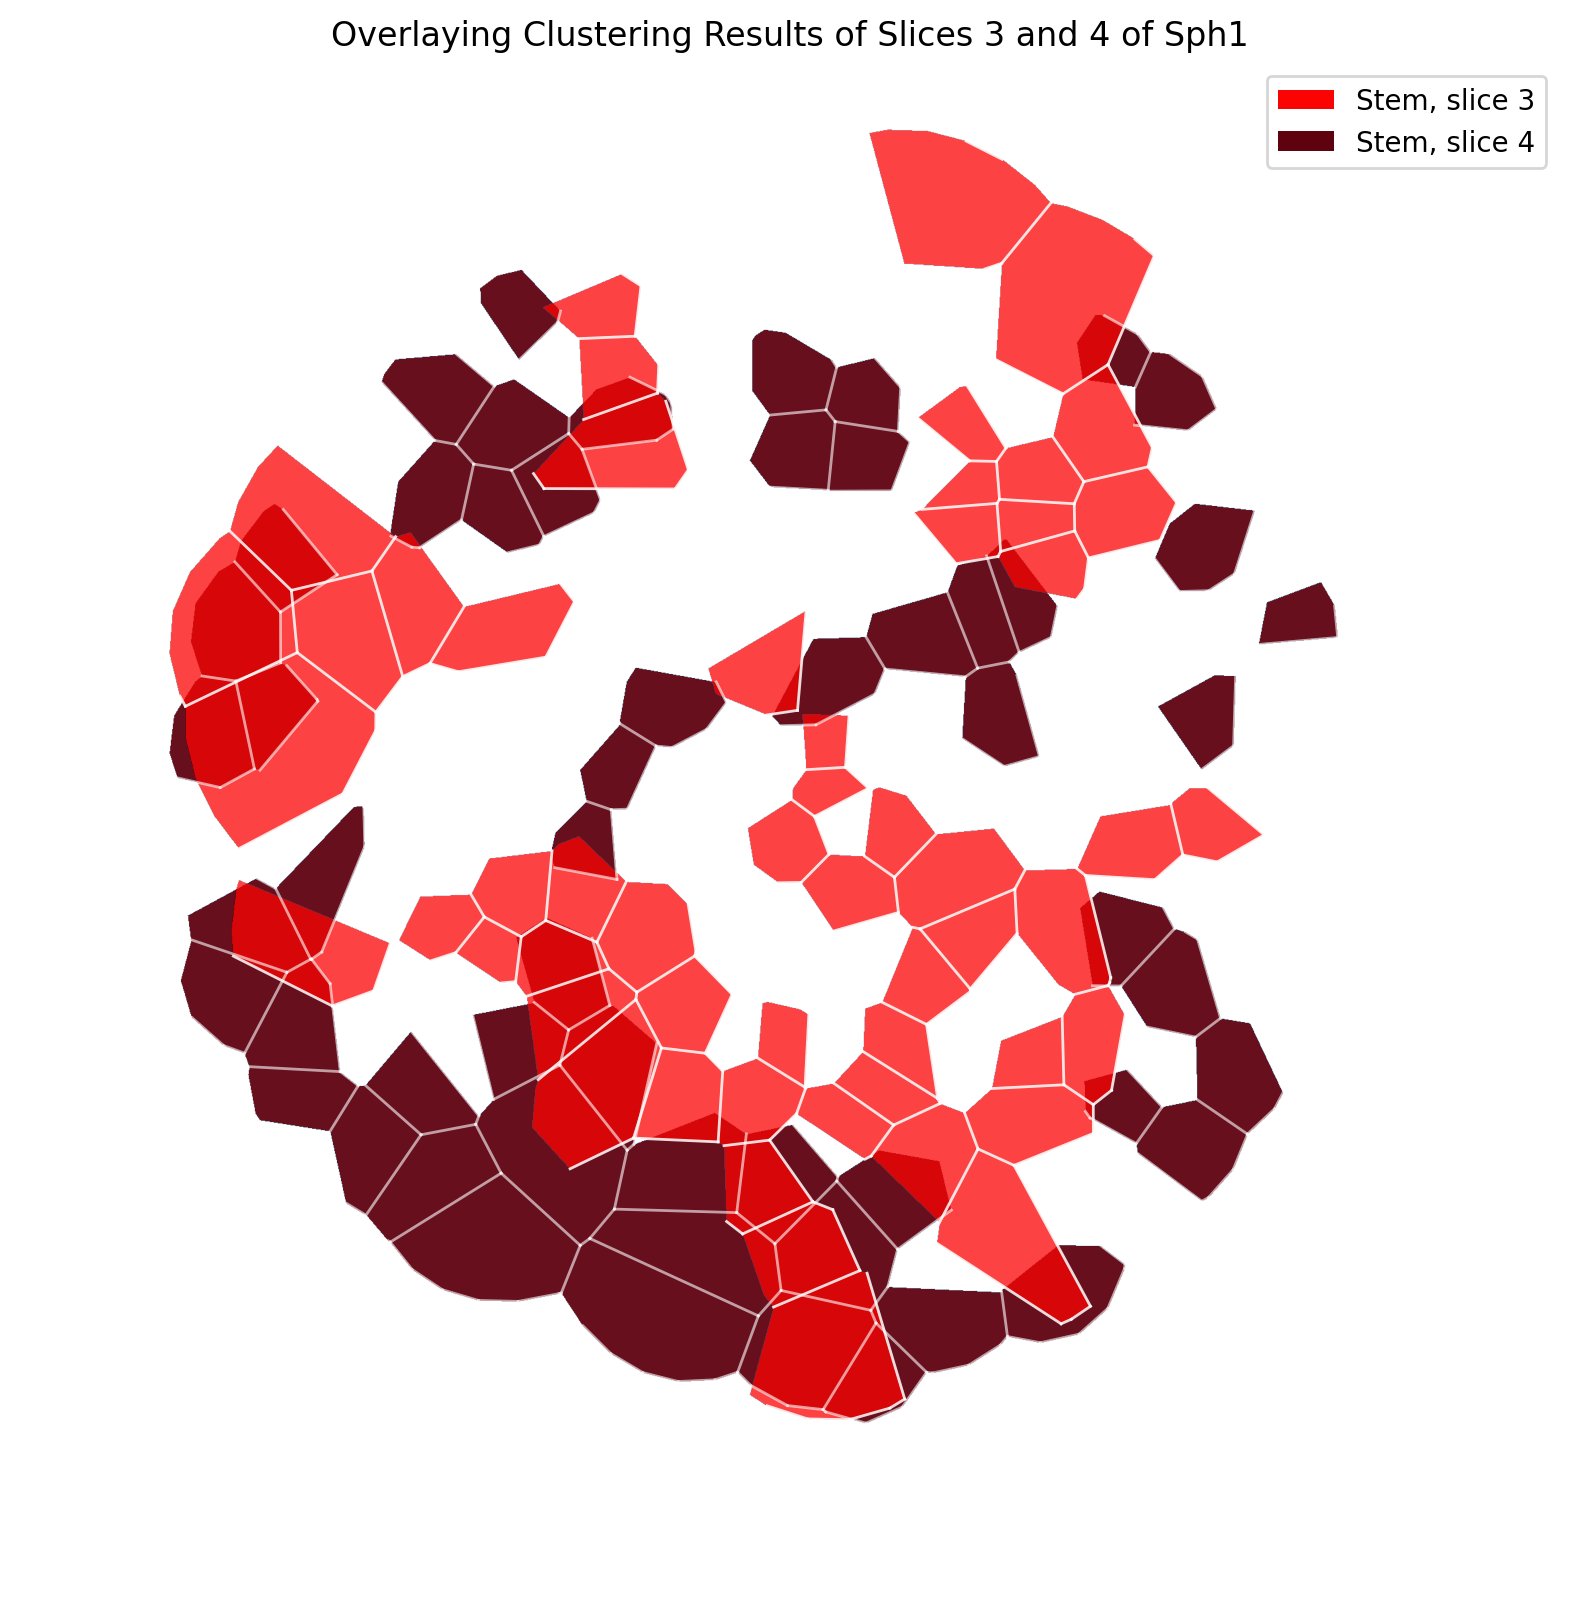

In [51]:
def plot_voronoi_on_mask(ax, vor, mask, line_color='white', line_width=1, line_alpha=0.9):
    """
    Plot Voronoi diagram on a given axis `ax` only on regions defined by `mask`.
    """
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            x0, y0 = vor.vertices[simplex[0]]
            x1, y1 = vor.vertices[simplex[1]]

            # Only plot the line if the midpoint is in the masked area
            mid_x, mid_y = (x0 + x1) / 2, (y0 + y1) / 2
            if mask[int(mid_y), int(mid_x)]:
                ax.plot([x0, x1], [y0, y1], color=line_color, lw=line_width, alpha=line_alpha)

# Create masks for stem cells
mask_z3 = voronoi_overlay_z3_copy[:, :, 3] > 0  # non-transparent pixels in z3 overlay
mask_z4 = voronoi_overlay_z4_copy[:, :, 3] > 0  # non-transparent pixels in z4 overlay

# Overlay the Voronoi diagram using the custom function
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.imshow(voronoi_overlay_z4_copy, alpha=0.95)
plot_voronoi_on_mask(ax, vor_in_sph_z4, mask_z4, line_alpha=0.6)
ax.imshow(voronoi_overlay_z3_copy, alpha=0.75)
plot_voronoi_on_mask(ax, vor_in_sph_z3, mask_z3, line_alpha=0.85)

# Legend for the Voronoi region colors
legend_labels = [
    Patch(facecolor=pastel_cmap_z3(1), label='Stem, slice 3'),
    Patch(facecolor=pastel_cmap_z4(1), label='Stem, slice 4')
]

ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral_z4.shape[1]])
ax.set_ylim([image_opened_bilateral_z4.shape[0], 0])
ax.set_title('Overlaying Clustering Results of Slices 3 and 4 of Sph1')
plt.axis('off')

plt.show()


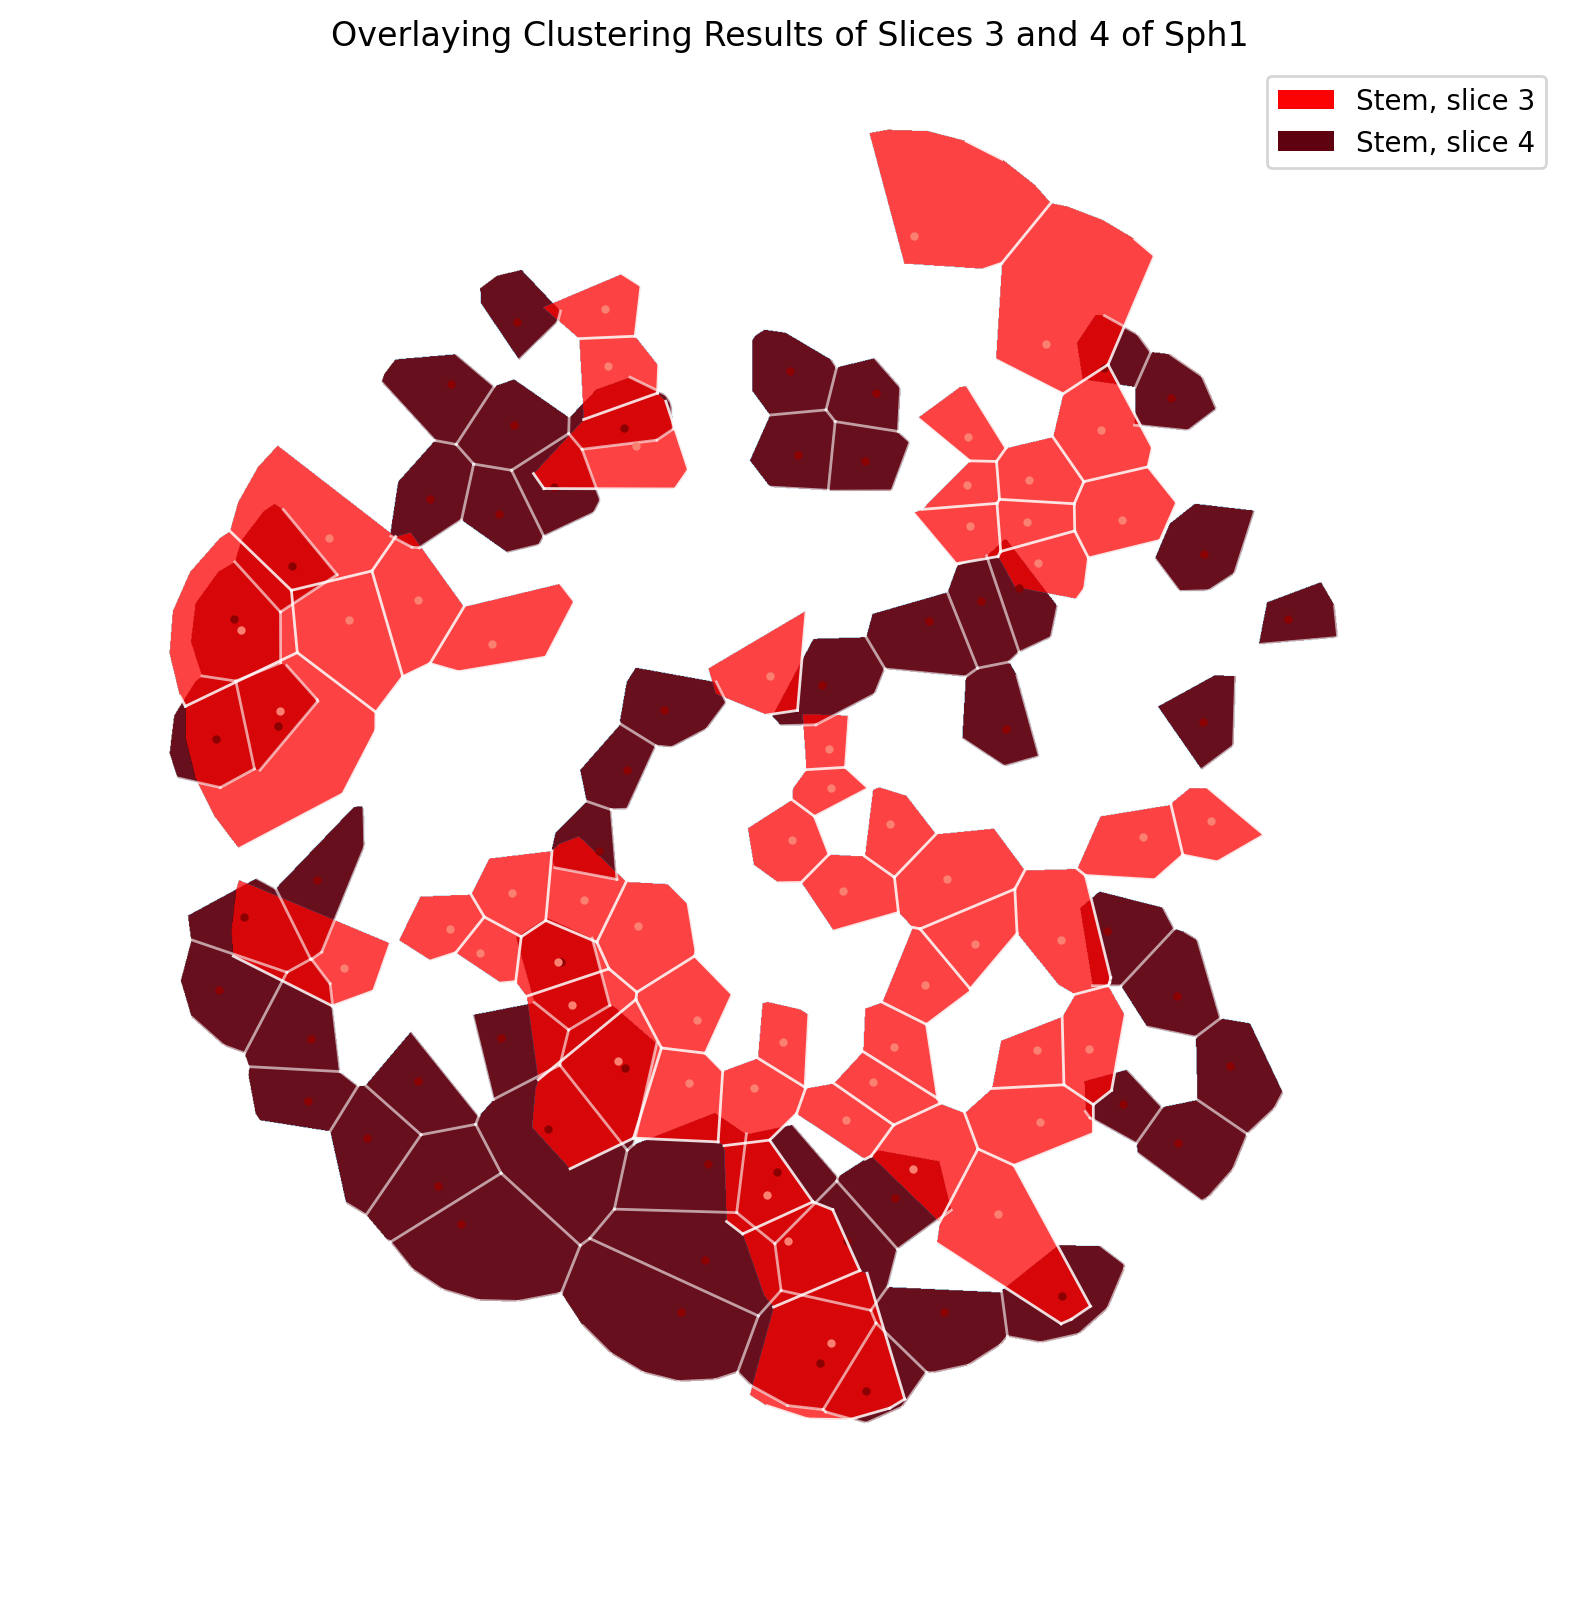

In [60]:
def plot_voronoi_on_mask(ax, vor, mask, line_color='white', line_width=1, line_alpha=0.9, point_color='yellow', point_size=2):
    """
    Plot Voronoi diagram and centroids on a given axis `ax` only on regions defined by `mask`.
    """
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            x0, y0 = vor.vertices[simplex[0]]
            x1, y1 = vor.vertices[simplex[1]]

            # Only plot the line if the midpoint is in the masked area
            mid_x, mid_y = (x0 + x1) / 2, (y0 + y1) / 2
            if mask[int(mid_y), int(mid_x)]:
                ax.plot([x0, x1], [y0, y1], color=line_color, lw=line_width, alpha=line_alpha)

    # Plot centroids
    for point_idx, region in enumerate(vor.point_region):
        if not -1 in vor.regions[region]:
            point = vor.points[point_idx]
            if mask[int(point[1]), int(point[0])]:
                ax.plot(point[0], point[1], color=point_color, marker='o', markersize=point_size)

# Overlay the Voronoi diagram using the custom function
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.imshow(voronoi_overlay_z4_copy, alpha=0.95)
plot_voronoi_on_mask(ax, vor_in_sph_z4, mask_z4, line_alpha=0.6, point_color='darkred')
ax.imshow(voronoi_overlay_z3_copy, alpha=0.75)
plot_voronoi_on_mask(ax, vor_in_sph_z3, mask_z3, line_alpha=0.85, point_color='salmon')

# Legend for the Voronoi region colors
legend_labels = [
    Patch(facecolor=pastel_cmap_z3(1), label='Stem, slice 3'),
    Patch(facecolor=pastel_cmap_z4(1), label='Stem, slice 4')
]

ax.legend(handles=legend_labels, loc='upper right')

ax.set_xlim([0, image_opened_bilateral_z4.shape[1]])
ax.set_ylim([image_opened_bilateral_z4.shape[0], 0])
ax.set_title('Overlaying Clustering Results of Slices 3 and 4 of Sph1')
plt.axis('off')

plt.show()